# UMAP and density plots shown in Supplementary Figure S2

In this notebook, we recreate:
1. the UMAP visualizations for
    1. Protein-coding gene expression data with or without batch correction. 
    2. Latent embeddings of normal tissues and tumor protein-coding gene expression data through the autoencoder and supervised deep neural networks. 
2. as well as density plots for agreement between attributions generated through models trained on mean-corrected and COMBAT-corrected data.

First, import libraries needed as well as relevant paths.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats
import matplotlib
import seaborn as sns
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

cmd_dir = "../results/paper_results/"
fig_dir = "../figures/"

binary_lncRNA = cmd_dir + "binary_lncRNA_unseen/"
binary_protein_coding = cmd_dir + "binary_protein_coding_unseen/"
binary_splicing = cmd_dir + "binary_splicing_unseen/"

file_names = ["part1_test_results.npz", "part2_test_results.npz", "part3_test_results.npz"]

def seed_everything(seed):
    import os
    import random
    import numpy as np

    print("current seed is", seed)

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed = 1234
seed_everything(seed)

current seed is 1234


# UMAP visualization for protein-coding gene expression data with or without batch correction (Supplementary Figure S2A)

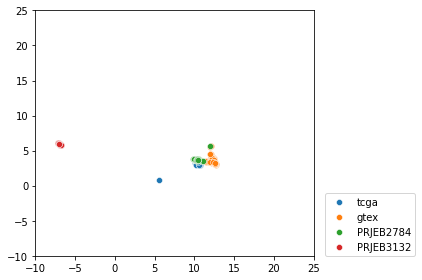

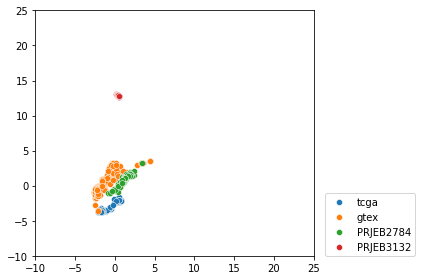

In [2]:
colormap = plt.cm.tab20b
colors = [colormap(0), colormap(4), colormap(8), colormap(12)] 

data_dict = np.load(cmd_dir + "mean_correct_umap.npz", allow_pickle=True)
x_data_unnorm = data_dict["uncorrected_data_umap"][()]
x_data_norm = data_dict["mean_corrected_data_umap"][()]

cnt=0
dataset_keys = ['tcga', 'gtex', 'PRJEB2784', 'PRJEB3132']
for ii in dataset_keys:
    color = colors[cnt]
    sns.scatterplot(x=x_data_unnorm[ii][:, 0], y=x_data_unnorm[ii][:, 1], label=ii)
    cnt += 1
    plt.xlim([-10,25])
    plt.ylim([-10,25])
plt.legend(loc=(1.04,0), shadow=False, scatterpoints=1)
plt.tight_layout()
plt.savefig(fig_dir + "before_batch_corr_lung_healthy.pdf")
plt.show()


cnt=0
for ii in dataset_keys:
    color = colors[cnt]
    sns.scatterplot(x=x_data_norm[ii][:, 0], y=x_data_norm[ii][:, 1], label=ii)
    cnt += 1
    plt.xlim([-10,25])
    plt.ylim([-10,25])
plt.legend(loc=(1.04,0), shadow=False, scatterpoints=1)
plt.tight_layout()
plt.savefig(fig_dir + "after_batch_corr_lung_healthy.pdf")
plt.show()


# UMAP visualization for the autoencoder latent embedding and supervised neural network latent embedding of protein-coding gene expression data from normal and tumor samples (Supplementary Figure S2B).

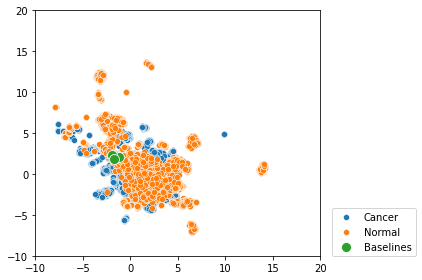

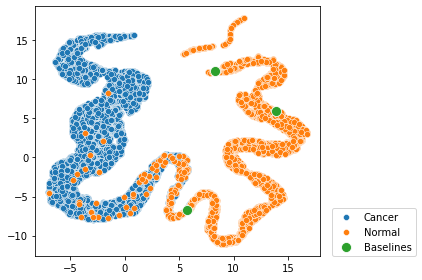

In [3]:
encodings = np.load(cmd_dir + "ae_and_last_layer_umap.npz", allow_pickle=True)

cancer_encodings = encodings['cancer_encodings'] 
normal_encodings = encodings['normal_encodings'] 
baseline_encodings = encodings['baseline_encodings'] 

sns.scatterplot(x=cancer_encodings[:,0], y=cancer_encodings[:,1], label="Cancer")
sns.scatterplot(x=normal_encodings[:,0], y=normal_encodings[:,1], label="Normal")
sns.scatterplot(x=baseline_encodings[:,0], y=baseline_encodings[:,1], s=100, label="Baselines")

plt.xlim([-10,20])
plt.ylim([-10,20])
plt.legend(loc=(1.04,0), shadow=False, scatterpoints=1)
plt.tight_layout()
plt.savefig(fig_dir + "embedding_layer_umap.pdf")
plt.show()

normal_encodings_pred = encodings['normal_encodings_pred'] 
cancer_encodings_pred = encodings['cancer_encodings_pred']
baseline_encodings_pred = encodings['baseline_encodings_pred'] 

# Plot normal, cancer encodings and baseline points
sns.scatterplot(x=cancer_encodings_pred[:,0], y=cancer_encodings_pred[:,1], label="Cancer")
sns.scatterplot(x=normal_encodings_pred[:,0], y=normal_encodings_pred[:,1], label="Normal")
sns.scatterplot(x=baseline_encodings_pred[:,0], y=baseline_encodings_pred[:,1],s=100, label="Baselines")

plt.legend(loc=(1.04,0), shadow=False, scatterpoints=1)
plt.tight_layout()
plt.savefig(fig_dir + "last_layer_umap.pdf", dpi=1000)
plt.show()

# Agreement between feature attributions from mean-corrected and COMBAT-corrected data (Supplementary Figure S2C).

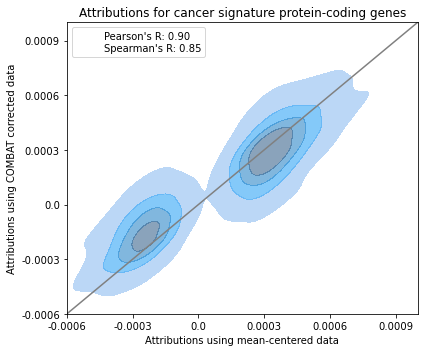

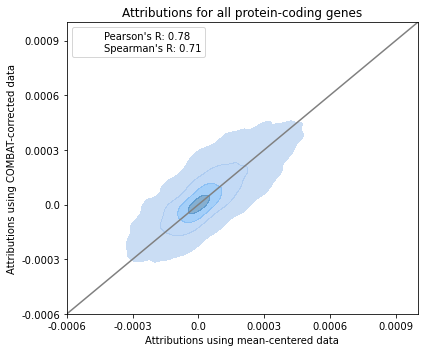

In [5]:
mean_corrected_attr = np.loadtxt(
    "../results/paper_results/protein_coding_genes_interpret_pvalues_abs.txt", 
    dtype=str)
combat_corrected_attr = np.loadtxt(
    "../results/paper_results/protein_coding_genes_interpret_pvalues_abs_bc.txt", 
    dtype=str)
best_feats = np.loadtxt("../results/paper_results/pc_genes_high.txt", delimiter="\t", dtype=str)

fig, ax = plt.subplots(figsize=(6,5))

x_all = []
y_all = []
not_found = []
for i in best_feats[:, 0]: 
    idx_mean = np.where(mean_corrected_attr[:, 0] == i)[0]
    idx_combat = np.where(combat_corrected_attr[:, 0] == i)[0]
    if len(idx_mean) > 0 and len(idx_combat) > 0:
        x_all.append(mean_corrected_attr[idx_mean, 1][0])
        y_all.append(combat_corrected_attr[idx_combat, 1][0])
    else:
        not_found.append(i)

assert len(not_found) == 0, "did not find all genes!"

x_all = np.array(x_all, dtype=float)
y_all = np.array(y_all, dtype=float)

pr = scipy.stats.pearsonr(x_all, y_all)[0]
sr = scipy.stats.spearmanr(x_all, y_all)[0]

sns.kdeplot(
    x=np.array(x_all, dtype=float),
    y=np.array(y_all, dtype=float),
    levels=5,
    fill=True,
    alpha=0.6,
    cut=2, 
    label = "Pearson's R: %.2f\nSpearman's R: %.2f"%(pr, sr)
)
x_diagonal = np.linspace(-0.001, 0.001, num=50)
plt.plot(x_diagonal, x_diagonal, color="gray")
plt.xlim([-0.0006, 0.001])
plt.ylim([-0.0006, 0.001])
ax.set_yticks([-0.0006, -0.0003, 0.0, 0.0003, 0.0006, 0.0009])
ax.set_xticks([-0.0006, -0.0003, 0.0, 0.0003, 0.0006, 0.0009])
ax.set_yticklabels([-0.0006, -0.0003, 0.0, 0.0003, 0.0006, 0.0009])
ax.set_xticklabels([-0.0006, -0.0003, 0.0, 0.0003, 0.0006, 0.0009])
ax.set_title("Attributions for cancer signature protein-coding genes")
ax.set_xlabel("Attributions using mean-centered data")
ax.set_ylabel("Attributions using COMBAT corrected data")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/density_bc.pdf")
plt.show()


fig, ax = plt.subplots(figsize=(6,5))

x_all = []
y_all = []
for i in mean_corrected_attr[:, 0]: 
    idx_mean = np.where(mean_corrected_attr[:, 0] == i)[0]
    idx_combat = np.where(combat_corrected_attr[:, 0] == i)[0]
    if len(idx_mean) > 0 and len(idx_combat) > 0:
        x_all.append(mean_corrected_attr[idx_mean, 1][0])
        y_all.append(combat_corrected_attr[idx_combat, 1][0])

x_all = np.array(x_all, dtype=float)
y_all = np.array(y_all, dtype=float)

pr = scipy.stats.pearsonr(x_all, y_all)[0]
sr = scipy.stats.spearmanr(x_all, y_all)[0]

sns.kdeplot(
    x=np.array(x_all, dtype=float),
    y=np.array(y_all, dtype=float),
    levels=5,
    fill=True,
    alpha=0.6,
    cut=2, label = "Pearson's R: %.2f\nSpearman's R: %.2f"%(pr, sr)
)
x_diagonal = np.linspace(-0.001, 0.001, num=50)
plt.plot(x_diagonal, x_diagonal, color="gray")
plt.xlim([-0.0006, 0.001])
plt.ylim([-0.0006, 0.001])
ax.set_yticks([-0.0006, -0.0003, 0.0, 0.0003, 0.0006, 0.0009])
ax.set_xticks([-0.0006, -0.0003, 0.0, 0.0003, 0.0006, 0.0009])
ax.set_yticklabels([-0.0006, -0.0003, 0.0, 0.0003, 0.0006, 0.0009])
ax.set_xticklabels([-0.0006, -0.0003, 0.0, 0.0003, 0.0006, 0.0009])
ax.set_title("Attributions for all protein-coding genes")
ax.set_xlabel("Attributions using mean-centered data")
ax.set_ylabel("Attributions using COMBAT-corrected data")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/density_bc_all.pdf")
plt.show()